In [1]:
import jax
import jax.numpy as jnp
from flax import nnx
from src import dataio, visualize, evaluate

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

/tmp/ipykernel_56227/1991717721.py:2: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated and will be removed in JAX v0.8.0; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


gpu


  0%|          | 0/60000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 27563.89it/s]


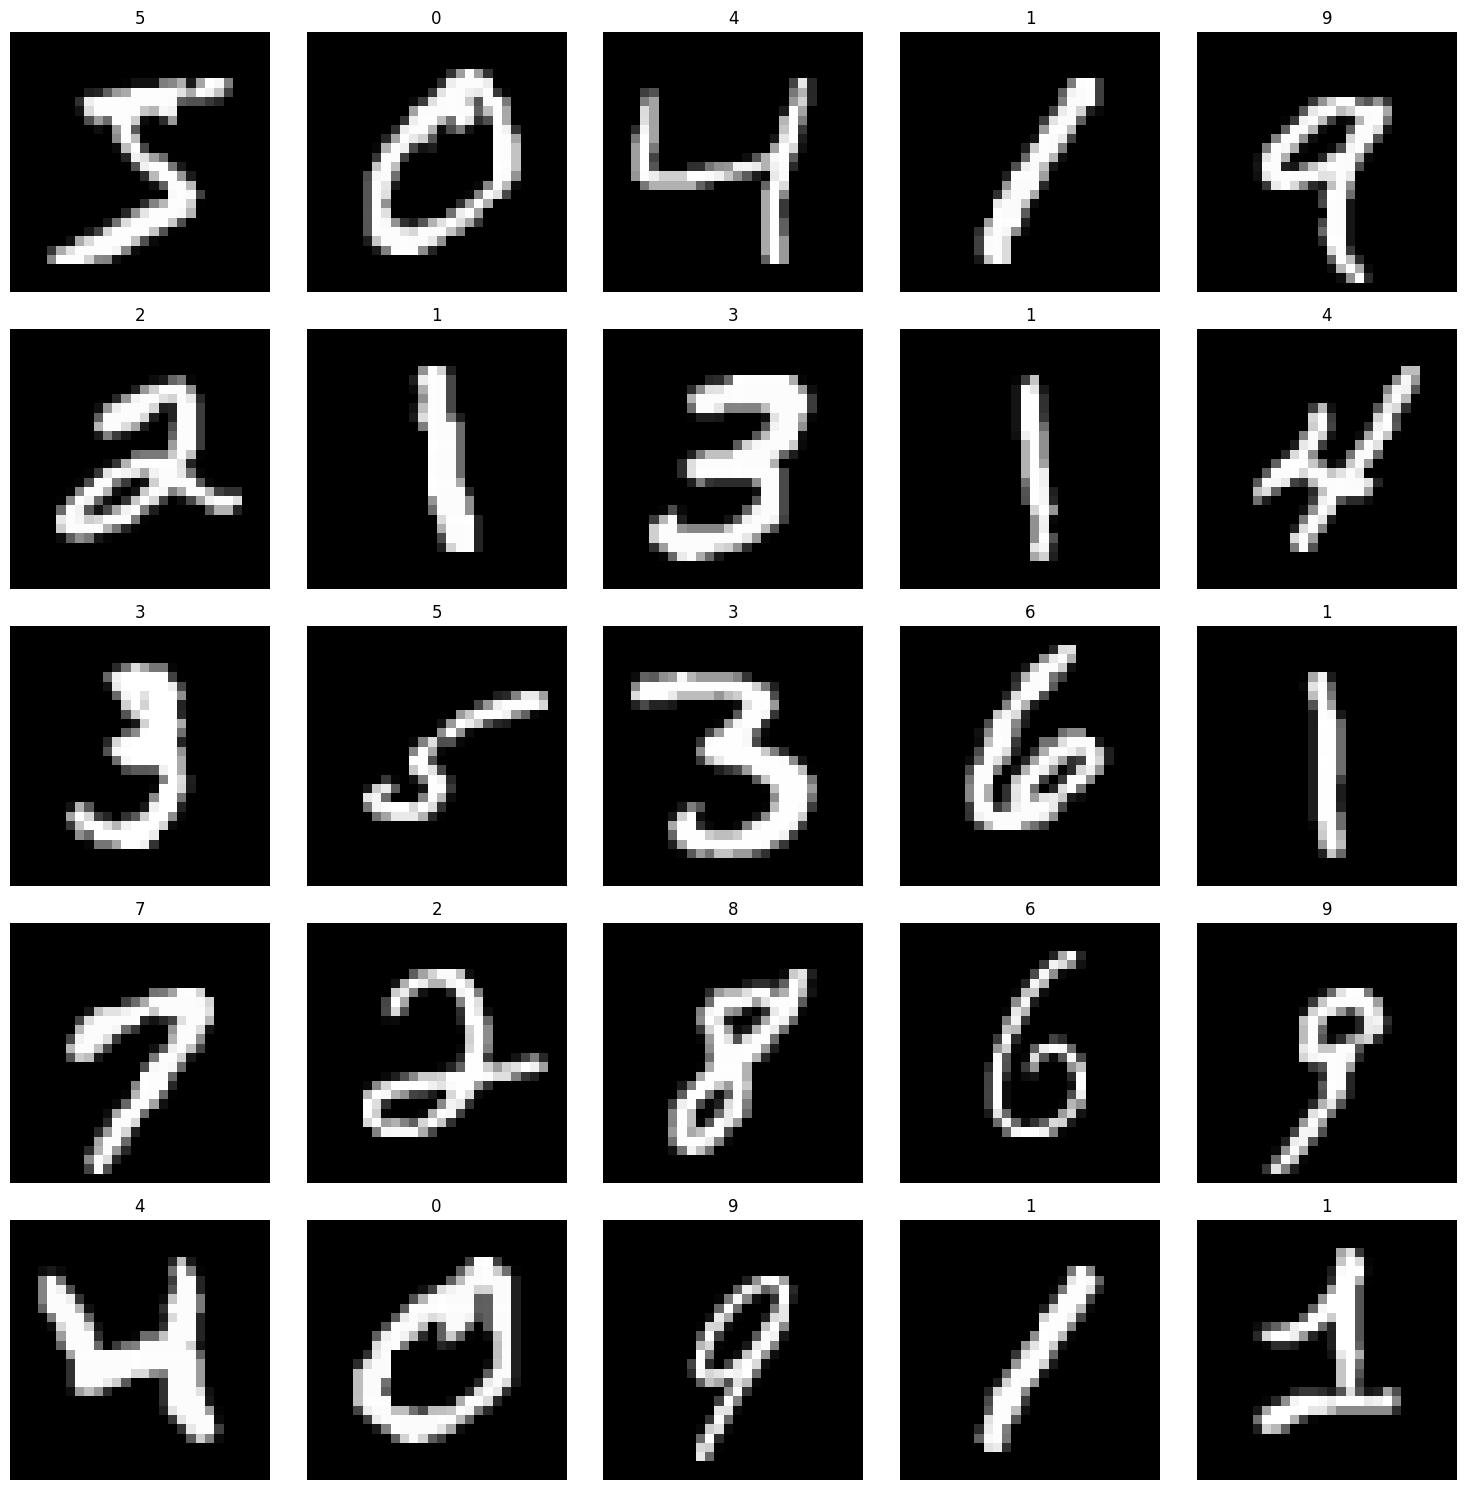

In [3]:
# データセットの読み込み
df_train, images_train = dataio.read_data('../dataset/train')
df_test, images_test = dataio.read_data('../dataset/test')
visualize.plot_images(images_train[:25], df_train, ncols=5, figsize=(15, 15))

In [4]:
class ReLU(nnx.Module):
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        return nnx.relu(x)
    
class AvgPool(nnx.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.kwargs = kwargs
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        return nnx.avg_pool(x, **self.kwargs)

class CNN(nnx.Module):
    """シンプルなCNNモデル"""
    def __init__(self, rngs: nnx.Rngs):
        super().__init__()
        self.conv_layer = nnx.Sequential(
            # 第1畳み込み層: 32フィルタ, 3x3カーネル
            nnx.Conv(in_features=1, out_features=32, kernel_size=(3, 3), padding='VALID', rngs=rngs),
            ReLU(),
            AvgPool(window_shape=(2, 2), strides=(2, 2), padding='VALID'),
            # 第2畳み込み層: 64フィルタ, 3x3カーネル
            nnx.Conv(in_features=32, out_features=64, kernel_size=(3, 3), padding='VALID', rngs=rngs),
            ReLU(),
            AvgPool(window_shape=(2, 2), strides=(2, 2), padding='VALID'),
        )
        self.linear_layer = nnx.Sequential(
            nnx.Linear(in_features=1600, out_features=256, rngs=rngs),
            ReLU(),
            nnx.Linear(in_features=256, out_features=10, rngs=rngs)
        )

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        """CNNモデルの順伝播

        Parameters
        ----------
        x : jnp.ndarray
            入力データ, shape: (b, 28, 28, 1)

        Returns
        -------
        jnp.ndarray
            出力データ, shape: (b, 10)
        """
        # 畳み込み層
        # (b, 1, 28, 28)
        x = self.conv_layer(x)

        # 全結合層への入力のために1次元にフラット化
        # (b, 1600)
        x = x.reshape((x.shape[0], -1))
        # 全結合層
        # (b, 256)
        x = self.linear_layer(x)
        return x

In [6]:
cnn = CNN(nnx.Rngs(0))
print(nnx.tabulate(cnn, jnp.ones((1, 28, 28, 1))))

                                                  CNN Summary                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                  ┃ type       ┃ inputs              ┃ outputs             ┃ Param                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                       │ CNN        │ float32[1,28,28,1]  │ float32[1,10]       │ 431,242 (1.7 MB)           │
├───────────────────────┼────────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ conv_layer            │ Sequential │ float32[1,28,28,1]  │ float32[1,5,5,64]   │ 18,816 (75.3 KB)           │
├───────────────────────┼────────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ conv_layer/layers/0   │ Conv       │ float32[1,28,28,1]  │ float32[1,26,26,32] │ bias: float32[32]          │
│                       │            │                     │                     │ kernel: float32[3,3,1,32]  │
│                       │            │                     │                     │                            │
│                       │            │                     │                     │ 320 (1.3 KB)               │
├───────────────────────┼────────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ conv_layer/layers/1   │ ReLU       │ float32[1,26,26,32] │ float32[1,26,26,32] │                            │
├───────────────────────┼────────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ conv_layer/layers/2   │ AvgPool    │ float32[1,26,26,32] │ float32[1,13,13,32] │                            │
├───────────────────────┼────────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ conv_layer/layers/3   │ Conv       │ float32[1,13,13,32] │ float32[1,11,11,64] │ bias: float32[64]          │
│                       │            │                     │                     │ kernel: float32[3,3,32,64] │
│                       │            │                     │                     │                            │
│                       │            │                     │                     │ 18,496 (74.0 KB)           │
├───────────────────────┼────────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ conv_layer/layers/4   │ ReLU       │ float32[1,11,11,64] │ float32[1,11,11,64] │                            │
├───────────────────────┼────────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ conv_layer/layers/5   │ AvgPool    │ float32[1,11,11,64] │ float32[1,5,5,64]   │                            │
├───────────────────────┼────────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ linear_layer          │ Sequential │ float32[1,1600]     │ float32[1,10]       │ 412,426 (1.6 MB)           │
├───────────────────────┼────────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ linear_layer/layers/0 │ Linear     │ float32[1,1600]     │ float32[1,256]      │ bias: float32[256]         │
│                       │            │                     │                     │ kernel: float32[1600,256]  │
│                       │            │                     │                     │                            │
│                       │            │                     │                     │ 409,856 (1.6 MB)           │
├───────────────────────┼────────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ linear_layer/layers/1 │ ReLU       │ float32[1,256]      │ float32[1,256]      │                            │
├───────────────────────┼────────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ linear_layer/layers/2 │ Linear     │ float32[1,256]      │ float32[1,10]      

In [7]:
from flax.training import train_state  # モデルパラメータなど学習に関する値を保持
import optax                           # loss関数やoptimizerが定義されている

metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

In [8]:
optimizer = nnx.Optimizer(
  cnn, optax.sgd(learning_rate=0.01, momentum=0.9), wrt=nnx.Param
)

In [9]:
def loss_fn(model: nnx.Module, image: jnp.ndarray, label: jnp.ndarray) -> jnp.ndarray:
    logits = model(image)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label
    ).mean()
    return loss, logits

# @nnx.jitは@jax.jitをWrapしているが，PythonObjectの追跡をするためOverheadがあり遅くなる模様
# さらなる高速化には以下の処理が必要
# https://flax.readthedocs.io/en/latest/guides/performance.html#functional-training-loop
@nnx.jit
def train_step(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, image: jnp.ndarray, label: jnp.ndarray) -> train_state.TrainState:
    """学習の1ステップを実行する関数

    Parameters
    ----------
    model : nnx.Module
        モデル
    optimizer : nnx.Optimizer
        オプティマイザ
    metrics : nnx.MultiMetric
        指標
    image : jnp.ndarray
        入力画像, shape: (b, 28, 28, 1)
    label : jnp.ndarray
        正解ラベル, shape: (b,)

    Returns
    -------
    train_state.TrainState
        更新後の学習状態
    """
    print("コンパイル中")
    # 自動微分を使用して勾配を計算
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, image, label)
    # Accuracyはupdateメソッドでlogits, labelsを引数に取り，精度を計算する
    metrics.update(loss=loss, logits=logits, labels=label)
    optimizer.update(model, grads)

In [10]:
num_epochs = 5
batch_size = 32
num_steps_per_epoch = images_train.shape[0] // num_epochs
metrics_history = {'train_loss': [],
                   'train_accuracy': []}

In [11]:
train_data = []
for i in range(0, images_train.shape[0], batch_size):
    train_data.append({
      'image': jnp.array(images_train[i:i + batch_size, ..., jnp.newaxis]) / 255.0,
      'label': jnp.array(df_train['label'][i:i + batch_size].values)
    })


In [12]:
# warmup (compile)
cnn.train()
train_step(cnn, optimizer, metrics, jnp.zeros_like(train_data[0]['image']), jnp.zeros_like(train_data[0]['label']))

cnn = CNN(nnx.Rngs(0))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)
optimizer = nnx.Optimizer(
  cnn, optax.sgd(learning_rate=0.01, momentum=0.9), wrt=nnx.Param
)

コンパイル中


In [13]:
def run():
    for epoch in range(num_epochs):
        # 計測値をリセット
        metrics.reset()
        for step, batch in enumerate(train_data):
            train_step(cnn, optimizer, metrics, batch['image'], batch['label'])

        for metric,value in metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)
        
        

        print(f"train epoch: {epoch}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")

In [14]:
evaluate.measure_runtime(run)


コンパイル中
train epoch: 0, loss: 0.21111547946929932, accuracy: 93.63999938964844
train epoch: 1, loss: 0.06787824630737305, accuracy: 97.94000244140625
train epoch: 2, loss: 0.04547460004687309, accuracy: 98.6500015258789
train epoch: 3, loss: 0.03379901871085167, accuracy: 99.0
train epoch: 4, loss: 0.02582523040473461, accuracy: 99.29500579833984
Runtime: 16.481328 seconds


# jax.jit版

In [15]:


# @nnx.jitは@jax.jitをWrapしているが，PythonObjectの追跡をするためOverheadがあり遅くなる模様
# さらなる高速化には以下の処理が必要
# https://flax.readthedocs.io/en/latest/guides/performance.html#functional-training-loop
@jax.jit
def jax_train_step(graphdef, state, image: jnp.ndarray, label: jnp.ndarray) -> train_state.TrainState:
    """学習の1ステップを実行する関数

    Parameters
    ----------
    image : jnp.ndarray
        入力画像, shape: (b, 28, 28, 1)
    label : jnp.ndarray
        正解ラベル, shape: (b,)

    Returns
    -------
    train_state.TrainState
        更新後の学習状態
    """
    print("コンパイル中")
    #　計算グラフと状態から各種オブジェクトを復元
    model, optimizer, metrics = nnx.merge(graphdef, state)
    def jax_loss_fn(model: nnx.Module) -> jnp.ndarray:
        logits = model(image)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=label
        ).mean()
        return loss
    # 自動微分を使用して勾配を計算
    loss, grads = nnx.value_and_grad(jax_loss_fn)(model)
    # Accuracyはupdateメソッドでlogits, labelsを引数に取り，精度を計算する
    optimizer.update(model, grads)
    logits = model(image)
    metrics.update(loss=loss, logits=logits, labels=label)
    
    state = nnx.state((model, optimizer, metrics))
    return loss, state

In [29]:
# warmup (compile)
cnn = CNN(nnx.Rngs(0))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)
optimizer = nnx.Optimizer(
  cnn, optax.sgd(learning_rate=0.01, momentum=0.9), wrt=nnx.Param
)

cnn.train()
graphdef, state = nnx.split((cnn, optimizer, metrics))
_, _ = jax_train_step(graphdef, state, jnp.zeros_like(train_data[0]['image']), jnp.zeros_like(train_data[0]['label']))

コンパイル中


In [30]:
def run(state):
    cnn.train()
    for epoch in range(num_epochs):
        # 計測値をリセット
        metrics.reset()
        for step, batch in enumerate(train_data):
            loss, state = jax_train_step(graphdef, state, batch['image'], batch['label'])
        nnx.update((cnn, optimizer, metrics), state)
        for metric,value in metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)
        
        

        print(f"train epoch: {epoch}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")

In [31]:
evaluate.measure_runtime(run, state=state)


train epoch: 0, loss: 0.2111026644706726, accuracy: 94.54499816894531
train epoch: 1, loss: 0.1395566165447235, accuracy: 96.413330078125
train epoch: 2, loss: 0.10826949030160904, accuracy: 97.2550048828125
train epoch: 3, loss: 0.08960474282503128, accuracy: 97.75875091552734
train epoch: 4, loss: 0.07693558931350708, accuracy: 98.107666015625
Runtime: 7.178759 seconds
